# CSCI-UA 0473 - Introduction to Machine Learning
## Wednesday, February 07, 2018

**Please download

This lab will discuss the difference between SVM and Logistic Regression, and go through the implementation of both using naive `numpy` (not really, because we are using `autograd` to skip manual computation of the gradients).

We will also go through the usage of `autograd` and `scipy.optimize.minimize()` in greater details, and take a look at numerical stability issues.

<div class="alert alert-info">
Survey: anyone has trouble understanding, or is familiar with: <ul>
<li> Python </li>
<li> `numpy` </li>
<li> Jupyter notebook </li>
    </ul> <br>
Throughout this course, we will also use `matplotlib` for plotting, `pandas` for tabular data manipulation
</div>

In [1]:
%matplotlib inline 

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad

import scipy.optimize
import matplotlib.pyplot as plot

import matplotlib

numpy.random.seed(1234)

## 1. Data Preparation

For now, we are using artificial toy dataset with two classes, each of which corresponds to a 2D Gaussian blob.

In [2]:
from sklearn.datasets import make_blobs

# Construct two 2D Gaussian blobs centered at (1, 1) and (-1, -1) respectively.
n_dim = 2
x_train, y_train = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1]], shuffle=True)
x_test, y_test = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1]], shuffle=True)

# sklearn.datasets comes with a lot of artificial and natural (easy) datasets.
# For a realistic-enough binary classification dataset, one can look at the
# UCI ML Breast Cancer Wisconsin (Diagnostic) Dataset:
# sklearn.datasets.load_breast_cancer()

In [3]:
# For SVMs, we expect the labels to be +1 and -1.
y_train_svm = (y_train * 2) - 1
y_test_svm = (y_test * 2) - 1

# We keep the 0-1 label for logistic regression.
y_train_lr = y_train.copy()
y_test_lr = y_test.copy()

In [4]:
print (y_train_svm)
print (y_train_lr)

[ 1 -1 -1 -1  1  1  1  1  1 -1  1 -1 -1  1  1 -1  1 -1 -1  1  1  1 -1 -1
 -1  1  1 -1  1  1  1  1 -1  1 -1 -1 -1  1 -1  1  1  1 -1  1  1 -1  1 -1
 -1  1  1  1  1  1  1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1  1 -1 -1  1
 -1  1 -1  1 -1 -1 -1 -1  1 -1  1 -1  1  1  1 -1 -1  1 -1 -1  1  1 -1 -1
 -1 -1  1 -1]
[1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0
 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1
 0 1 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 1 0]


## 2. Models Review


### 2.1 Logistic Regression

Recall that the logistic regression is a probabilistic model where (assuming the labels are given as 0 and 1)
$$p(y^*_i=1\mid \mathbf{x}_i) = M(\mathbf{x}_i) = \mathrm{sigmoid}(\mathbf{w}^T \mathbf{x}_i) = \dfrac{1}{1 + \exp(-\mathbf{w}^T x_i)}$$

If we only want the classification result rather than the probability, we can simply check the sign of $\mathbf{w}^T \mathbf{x}_i$ without going through the sigmoid function.

We find $\mathbf{w}$ by minimizing the average *negative log probability* (which is equivalent to [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation))

$$
D_\mathrm{lr}(y_i, M, \mathbf{x}_i) = -y_i \log M(\mathbf{x}_i) - (1 - y_i) \log (1 - M(\mathbf{x}_i))
$$

#### 2.1.1 Bias term

For simplicity, we usually omit the bias term $b$ when writing the math formulation, assuming that $\mathbf{x}$ includes the constant element 1 (Why the 1 is necessary?  This is in one of your homework).  In practice, we often add the bias term explicitly, that is:

$$
p(y^*_i=1\mid \mathbf{x}_i) = M(\mathbf{x}_i) = \mathrm{sigmoid}(\mathbf{w}^T \mathbf{x}_i + b) = \dfrac{1}{1 + \exp(-\mathbf{w}^T x_i + b)}
$$

From now on, we will continue omitting the bias term $b$ in math formulations, but code it explicitly in implementations.

#### 2.1.2 Logistic Loss

An alternative of the empirical cost function for Logistic Regression is the *logistic loss*, assuming that the labels are given as +1 and -1:

$$
D_\mathrm{log}(y_i, M, \mathbf{x}_i) = \sum_{i=1}^N \dfrac{1}{\log 2} \log \left(1 + \exp (-y_i \mathbf{w}^T \mathbf{x}_i)\right)
$$

<del>Unfortunately, </del>the equivalence between logistic loss and negative log probability is left as a later homework assignment.

### 2.2 SVM

SVM classifies examples by checking the sign of $\mathbf{w}^T \mathbf{x}_i$ as well.  However the empirical cost function (hence the learning rule) is different:

$$
J(\mathbf{w}, D_{\mathrm{tra}}) = \dfrac{1}{N} \sum_{i=1}^N \max \left(0, 1 - y_i \mathbf{w}^T \mathbf{x}_i\right) + \lambda \lVert \mathbf{w} \rVert^2
$$

where $\lambda$ is a constant.  In the lecture note, $\lambda = \dfrac{C}{2}$.

### 2.3 Loss curves of both functions

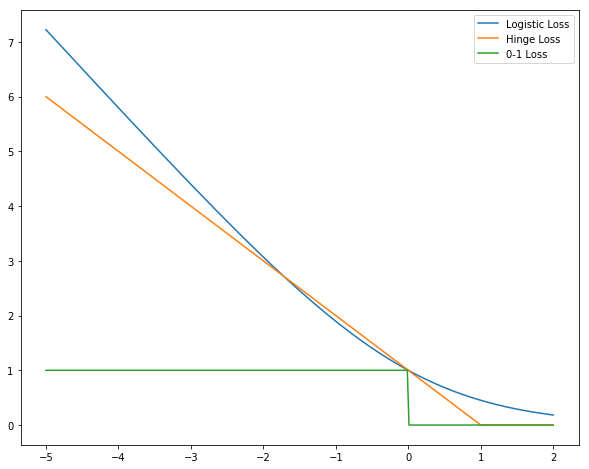

In [5]:
x = numpy.linspace(-5, 2, 300)
log_loss = 1. / numpy.log(2) * numpy.log(1 + numpy.exp(-x))
hinge_loss = numpy.maximum(0, 1 - x)
zero_one_loss = (x < 0)
plot.gcf().set_size_inches(10, 8)
plot.plot(x, log_loss, label='Logistic Loss')
plot.plot(x, hinge_loss, label='Hinge Loss')
plot.plot(x, zero_one_loss, label='0-1 Loss')
plot.legend(loc='best')
plot.show()

## 3. Implementation

### 3.1 Logistic Regression (code review)

Most of the code for Logistic Regression is available in the previous lab.

<div class="alert alert-info">
**Hint**: To write efficient `numpy` code, use as few operations as possible.
</div>

<div class="alert alert-warning">
**Beware**: When coding any mathematical expression, keep an eye on potential *numerical stability issues*.  Careless implementations may yield inaccurate results, exhibit bizarre behavior or even crash.  The most horrible numerical instabilities include overflow (e.g. `numpy.log(1 + numpy.exp(800))`) and underflow (e.g. `numpy.log(0.8 ** 1000000)`).
</div>

<div class="alert alert-danger">
Please answer the four questions in the following cell.  *You do not need to code anything.*
</div>

In [6]:
# The sigmoid function
def sigmoid(x):
    ########## QUESTION 1 ##########
    # What will happen if x = 10000?  How about -10000?
    return 1. / (1. + numpy.exp(-x))

# The prediction function
# x is either 2D array with shape (num_samples, num_features), i.e., each row is a training sample vector,
# or a 1D array containing a single sample vector.
# params is a 1D array with shape (num_features + 1,) representing the weight vector plus a bias.
# pre: whether we want a pre-sigmoid value (between -inf and inf) or an actual probability (between 0 and 1)
def logreg(x, params, pre=False):
    w, b = params[:-1], params[-1]
    ########## QUESTION 2 ##########
    # Can we make the following two statements more efficient?
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    y = numpy.sum(x * w, axis=1) + b
    
    if pre:
        return y
    return sigmoid(y)

# The distance (cost) function, either per-sample or average
def logreg_dist(y, x, params, avg=False):
    y_ = logreg(x, params)
    ########## QUESTION 3 ##########
    # What will happen if the small constant 1e-12 is removed?
    d = -(y * numpy.log(y_ + 1e-12) + (1. - y) * numpy.log(1. - y_ + 1e-12))
    
    if not avg:
        return d
    return numpy.mean(d)

# The empirical cost function
def logreg_cost(params, x, y):
    return logreg_dist(y, x, params, avg=True)

# The next thing we need is the gradient function, which can be easily computed via autograd.grad().
# autograd.grad() takes in a function f and the index of argument x with respect to which the gradient would be computed.
# It then returns a function.  That function has the same argument list as f, but it returns df/dx instead.
# Example:
# >>> def f(x):
# ...     return x ** 2
# >>> df_dx = grad(f) # 2 * x
# >>> print(df_dx(5.))
# 10.0
# >>> def g(x, y):
# ...     return (x @ y).sum()
# >>> dg_dx = grad(g, 0) # y
# >>> dg_dy = grad(g, 1) # x
# >>> x = numpy.array([1., 2., 3.])
# >>> y = numpy.array([4., 5., 6.])
# >>> print(dg_dx(x, y), dg_dy(x, y))
# [4. 5. 6.] [1. 2. 3.]
#
# Here, we compute the gradient of cost with respect to the parameters
logreg_rule = grad(logreg_cost)

########## QUESTION 4 ##########
# Do you expect logreg_rule(params, x, y) would give the correct gradients w.r.t. params, given the following values?
#x = numpy.array([10000., 10000.])
#y = numpy.array(1.)
#params = numpy.array([-1., -1., -1.])
#print(logreg_rule(params, x, y))

### 3.2 SVM

For reference, the score function is simply $\mathbf{w}^T \mathbf{x}$, and the empirical cost function is

$$
J(\mathbf{w}, D_{\mathrm{tra}}) = \dfrac{1}{N} \sum_{i=1}^N \max \left(0, 1 - y_i \mathbf{w}^T \mathbf{x}_i\right) + \lambda \lVert \mathbf{w} \rVert^2
$$

<div class="alert alert-danger">
Please fill in the `YOUR CODE HERE` sections with your implementation.
</div>

In [7]:
# The prediction function
# x is either 2D array with shape (num_samples, num_features), i.e., each row is a training sample vector,
# or a 1D array containing a single sample vector.
# params is a 1D array with shape (num_features + 1,) representing the weight vector plus a bias.
# pre: whether we want a pre-sign value (between -inf and inf) or the actual class label (-1 or +1)
def svm(x, params, pre=False):
    # (1)
    # Get the bias term from the last element of @params, and get the weight vector from the rest.
    # YOUR CODE HERE
    
    # (2)
    # Compute the score.  Do not forget the bias term!
    # Your score should be a 1D array with num_samples elements for a 2D @x, or a scalar for a 1D @x.
    # YOUR CODE HERE
    
    # (3) If @pre is True, return the score itself.  Otherwise, return the sign of the score.
    # YOUR CODE HERE
    
    # (4) Delete the "pass" statement if you have completed everything above.
    pass

# Empirical cost function.
# y: 1D array or a scalar containing the ground truth label(s).  Each element is either +1 or -1.
# x: 2D array or 1D array containing the examples.
# params: 1D array with shape (num_features + 1)
# avg: whether we want the per-example hinge loss or the empirical cost function
def svm_dist(y, x, params, avg=False, lambda_=1):
    # (1)
    # Call svm() to get the pre-sign score.
    # YOUR CODE HERE
    
    # (2)
    # Compute hinge loss, which is the "max" term within the summation, for each example.
    # YOUR CODE HERE
    
    # (3)
    # If avg is False, return the per-example hinge loss.  Otherwise, return the empirical cost function.
    # Recall that the cost function is the sum of an average and a norm.
    # YOUR CODE HERE
    
    # (4) Delete the "pass" statement if you have completed everything above.
    pass

def svm_cost(w, x, y, lambda_=1):
    return svm_dist(y, x, w, avg=True, lambda_=lambda_)

# Compute the gradient.
svm_rule = None   # YOUR CODE HERE: replace None with the correct function call.

## 3. Training

The cost functions for both Logistic Regression and SVM are [*convex*](https://en.wikipedia.org/wiki/Convex_function).  This is good news since (1) if the gradient w.r.t. the weight is 0, then this is guaranteed to be optimal, and (2) we have a lot of efficient methods to find the optimal solution.

The detail of convex optimization is out of scope of the course.  Here, we will focus on how to optimize Logistic Regression or SVM using `scipy`.

### 3.1 Logistic Regression

<div class="alert alert-danger">
Please fill in the `YOUR CODE HERE` section with your implementation.
</div>

In [8]:
# Initialize the parameters
# Usually, we randomly initialize weights, but set the bias term to 0.
params = 0.01 * numpy.random.randn(n_dim+1); params[-1] = 0.

# Use scipy.optimize.minimize to perform convex optimization.
# You can read the documentation for the complete description, but here's the most common use case:
# result = scipy.optimize.minimize(f, x0, other_arguments, method=None, jac=None)
# where
# @f: the function you want to minimize.  It takes @x0 as the first argument, and the rest from @other_arguments
# @x0: the initial value of x.
# @other_arguments: a list of other arguments to be passed into @f.
# @method: generally safe to leave as None, although you can select your own method.
# @jac: the function taking exactly the same arguments as @f and returning df/dx.  Thanks to autograd we already have it.
# It returns some structure.  The ones you would probably care the most are
# result.x: the final x which gives the minimum.
# result.success: whether the optimization succeeded or not.
logreg_model = scipy.optimize.minimize(logreg_cost, params, (x_train, y_train_lr), jac=logreg_rule) # YOUR CODE HERE: replace None with the function call.

params_logreg = logreg_model.x
print(logreg_model)

      fun: 0.07998633403091687
 hess_inv: array([[264.28569314, 122.75975385, -28.36390998],
       [122.75975385,  88.76965559,  -8.17803123],
       [-28.36390998,  -8.17803123,  41.21222803]])
      jac: array([ 2.26436220e-07, -7.08259851e-07,  1.46381694e-06])
  message: 'Optimization terminated successfully.'
     nfev: 25
      nit: 24
     njev: 25
   status: 0
  success: True
        x: array([-4.96315298, -2.4785896 ,  0.57546102])


### 3.2 SVM

<div class="alert alert-danger">
Please fill in the `YOUR CODE HERE` section with your implementation.
</div>

In [21]:
params = 1e-4 * numpy.random.randn(n_dim+1); params[-1] = 0.

# (1) Call scipy's minimize method on SVM.
svm_model = None # YOUR CODE HERE: replace None with the function call.

params_svm = svm_model.x

print (svm_model)

      fun: 0.8046621480618523
 hess_inv: array([[ 0.35451578,  0.01982312, -0.08619842],
       [ 0.01982312,  0.50390576, -0.02388847],
       [-0.08619842, -0.02388847,  0.64111681]])
      jac: array([1.43057135e-03, 3.61112681e-03, 4.77549933e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 84
      nit: 7
     njev: 79
   status: 2
  success: False
        x: array([-0.28753254, -0.21638255,  0.03182057])


### 3.3 Visualization and Analysis

In [10]:
# Visualize data
# x: a 2D array with shape (num_samples, 2); each example vector has two components only
# y: a 1D array with shape (num_samples,); each element is a label of the example vector, taking either 0 or 1
# c: color, 'r' for red, 'g' for green, etc.  See the documentation of matplotlib.pyplot.plot for more.
# title: the title of the figure
def vis_data(x, y = None, c='r', title = ''):
    if y is None: 
        y = [None] * len(x)
    for x_, y_ in zip(x, y):
        if y_ is None:
            # We either use matplotlib.pyplot.plot() or matplotlib.pyplot.scatter() to draw scatter plots.
            # A common use case is
            # matplotlib.pyplot.plot(x, y, marker)
            # where marker is usually a combination of style and color (e.g. 'r+' for red pluses, 'gx' for green crosses)
            plot.plot(x_[0], x_[1], c + 'o')
        else:
            plot.plot(x_[0], x_[1], c + 'o' if y_ == 0 else c + '+')
    # Turn on the grid and set the title
    plot.grid('on')
    plot.title(title)

In [11]:
def vis_hyperplane(w, typ='k--', label=None):
    
    # Matplotlib organizes the plots into figures and axes.
    # Each axis handles the style of x-axis, y-axis, and the actual plot inside.
    # Each figure can contain multiple axes.
    # Here, we need to get the range of x and y of the current axis, compute the intersection of the hyperplane and the
    # window, and draw a line.
    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    m0, m1 = lim0[0], lim0[1]

    intercept0 = -(w[0] * m0 + w[-1])/w[1]
    intercept1 = -(w[0] * m1 + w[-1])/w[1]
    
    plt1, = plot.plot([m0, m1], [intercept0, intercept1], typ, label=label)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    return plt1

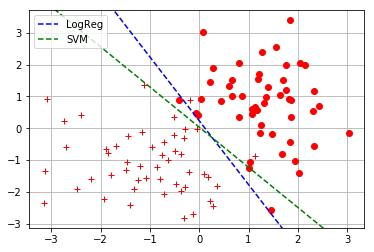

LogReg: -5.0 x_1 + -2.5 x_2 + 0.58 = 0
SVM: -0.37 x_1 + -0.29 x_2 + 0.01 = 0


In [12]:
# Make a new figure and visualize the data and hyperplane
plot.figure()

vis_data(x_train, y_train_lr, c='r')

plt0 = vis_hyperplane(params_logreg, 'b--', label='LogReg')
plt1 = vis_hyperplane(params_svm, 'g--', label='SVM')

plot.legend(loc='best')

plot.show()

print ('LogReg: {:.2} x_1 + {:.2} x_2 + {:.2} = 0'.format(*list(params_logreg)))
print ('SVM: {:.2f} x_1 + {:.2f} x_2 + {:.2f} = 0'.format(*list(w_svm)))

If you implemented SVM correctly, the decision boundaries should be (somehow) similar.

For most real-world scenarios, Logistic Regression and SVM indeed perform comparably.  However, we can construct some corner cases to show the difference between the two.

### 3.4 Yet another visualization and analysis

In [13]:
x_train_more, y_train_more = make_blobs(n_samples=10, n_features=n_dim, centers=[[3, 3]], shuffle=True)
x_test_more, y_test_more = make_blobs(n_samples=10, n_features=n_dim, centers=[[3, 3]], shuffle=True)

In [14]:
print (y_train_more)

y_train_more[y_train_more == 0] = 1
y_test_more[y_test_more == 0] = 1

print (y_train_more)

[0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1]


In [15]:
# Append the new data points to the existing set of 100 training and test points

x_train = numpy.vstack((x_train, x_train_more))
x_test = numpy.vstack((x_test, x_test_more))

y_train_lr = numpy.append(y_train_lr, y_train_more)
y_test_lr = numpy.append(y_test_lr, y_test_more)

y_train_svm = numpy.append(y_train_svm, (y_train_more * 2) - 1)
y_test_svm = numpy.append(y_test_svm, (y_test_more * 2) - 1)

In [16]:
print ('Number of training points: ', x_train.shape)

Number of training points:  (110, 2)


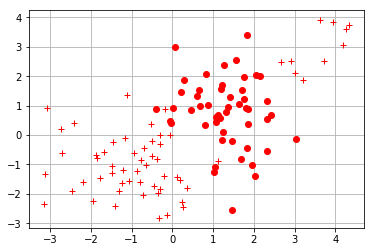

In [17]:
vis_data(x_train, y_train_lr, c='r')

In [19]:
######## Logistic Regression ########
params = 0.01 * numpy.random.randn(n_dim+1); params[-1] = 0.

logreg_model = scipy.optimize.minimize(logreg_cost, params, (x_train, y_train_lr), method='L-BFGS-B', jac=logreg_rule)

params_logreg = logreg_model.x

print (logreg_model)


####### SVM #######
params = 1e-4 * npr.randn(n_dim+1); params[-1] = 0.

svm_model = scipy.optimize.minimize(svm_cost, params, (x_train, y_train_svm), 
                              method='L-BFGS-B', jac=svm_rule)

params_svm = svm_model.x

print (params_svm)

[-0.54705885 -0.18092149  0.48085362]
[-0.28730715 -0.21710233  0.03246194]


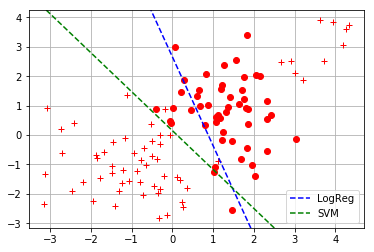

LogReg: -0.55 x_1 + -0.18 x_2 + 0.48 = 0
SVM: -0.29 x_1 + -0.22 x_2 + 0.03 = 0


In [20]:
plot.figure()

vis_data(x_train, y_train_lr, c='r')

plt0 = vis_hyperplane(params_logreg, 'b--')
plt1 = vis_hyperplane(params_svm, 'g--')

plot.legend([plt0, plt1], ['LogReg', 'SVM'], loc='best')

plot.show()

print ('LogReg: {:.2} x_1 + {:.2} x_2 + {:.2} = 0'.format(*list(params_logreg)))
print ('SVM: {:.2f} x_1 + {:.2f} x_2 + {:.2f} = 0'.format(*list(params_svm)))

### 3.5 Conclusion

We can see from the examples above that **Logistic Regression seems more sensitive to outliers than SVM**.

<div class="alert alert-danger">
**Question**: why is it so?
</div>

## 4 Some more stuff to try?

If you are interested at all,

1. Rewrite the logistic regression so that it is more accurate for extreme values.
2. Try both models on a more realistic, high-dimensional dataset.  `sklearn.datasets` provides a bunch of realistic datasets to play with.
3. How should we choose between Logistic Regression and SVM (and other models), and for SVMs, how do we choose $\lambda$?

<div class="alert alert-danger">
**Note**: The tasks above and their variations [**MAY**](https://www.ietf.org/rfc/rfc2119.txt) appear in future homework!
</div>